In [1]:
import numpy as np
import pywt
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio

In [2]:
def fade(buf, fade_dir, fade_type):
    if fade_dir not in ["in", "out"]:
        raise ValueError('fade_dir must be "in" or "out"')

    match fade_type:
        case "linear":
            fade = np.linspace(0, 1, len(buf))
        case "cosine":
            fade = 0.5 * np.cos(np.pi * np.linspace(1, 0, len(buf))) + 0.5
        case _:
            raise ValueError("unsupported fade_type")
            sys.exit(1)

    if fade_dir == "out":
        return buf * fade[::-1]
    return buf * fade

fl 32 has max 0.007784821093082428


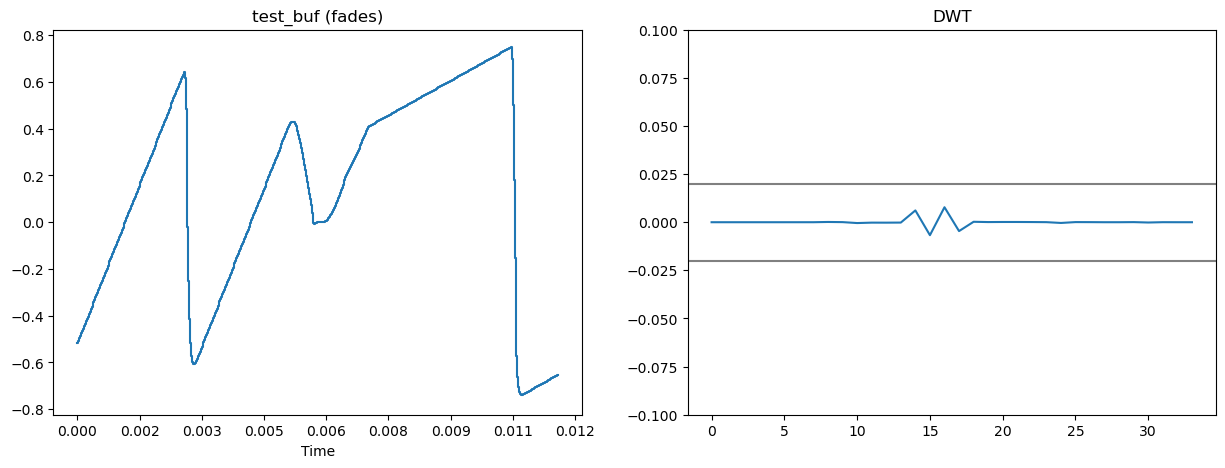

In [6]:
audio_data, audio_sr = librosa.load('test_audio_2.wav', sr=44100)
audio_data = librosa.util.normalize(audio_data)

test_buf_len = 512
test_buf_c = int(test_buf_len / 2)

# vary this value by powers of 2 to see how the DWT graph changes
fl = 32

test_buf = np.concatenate((audio_data[-test_buf_c:], audio_data[:test_buf_c])) # creat test buffer from last C samples + first C samples of input
test_buf[test_buf_c-fl:test_buf_c] = fade(test_buf[test_buf_c-fl:test_buf_c], 'out', 'cosine') # apply fade out
test_buf[test_buf_c:test_buf_c+fl] = fade(test_buf[test_buf_c:test_buf_c+fl], 'in', 'cosine') # apply fade in

cA, cD2, cD1 = pywt.wavedec(test_buf, 'db4', level=2) # db4 wavelet decomposition
cD2 = cD2[int(len(cD2)*3/8):int(len(cD2)*5/8)] # using level 2, but we only need the center
cD2 *= librosa.filters.get_window('parzen', len(cD2)) # window to avoid false positives on the edges

# write back to the audio file
audio_data[-test_buf_c:] = test_buf[:test_buf_c]
audio_data[:test_buf_c] = test_buf[test_buf_c:]

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,5))
librosa.display.waveshow(test_buf, sr=audio_sr, ax=ax1)
ax2.plot(cD2)
ax2.set_ylim(-0.1,0.1)
ax2.axhline(y=0.02, color='grey')
ax2.axhline(y=-0.02, color='grey')

ax1.set(title='test_buf (fades)')
ax2.set(title='DWT')
print(f"fl {fl} has max {np.max(np.abs(cD2))}")
Audio(np.concatenate((audio_data, audio_data)), rate=audio_sr)